The goal of this take home exercise is to train a model that would predict whether a listing would be booked or not. To train the model a dataset with a variety of features has been provided. This report summarizes our data analysis, modeling methodology and findings. An outline of the report follows. In the first section, our goal is to analyze and understand the data. Next, we aim to clean and transform the feature values in a format that is more amenable to the modeling task at hand. Thereafter, we present our modeling choices with appropriate justifications and evaluate the models learned. Subsequently, we highlight a few insights that one can draw from the dataset by closely inspecting the learned models. Finally, we wrap up the report with a few concluding thoughts.

# Part A: Data Exploration

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from pandas.io.json import json_normalize
import json

#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# set some display options for pretty printing
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display
pd.set_option("display.max_rows",5)
pd.set_option("display.max_columns",4)
pd.set_option('precision',2)
pd.set_option('float_format', '{:.2f}'.format)

plt.style.use('seaborn-poster')

## Eyeball data and generate summary statistics

In [3]:
raw_data = pd.read_csv('/Users/avishek2/Desktop/anb/TH_data_challenge.tsv',sep='\t')
raw_data

,dim_is_requested,ds_night,...,r_kdt_m_effective_daily_price_available_n100_p50,r_kdt_m_effective_daily_price_booked_n100_p50
0,False,2015-01-06,...,75.00,98.00
1,True,2015-01-21,...,65.00,42.00
...,...,...,...,...,...
184277,False,2015-10-07,...,271.50,228.00
184278,False,2015-12-15,...,250.00,145.00


In [4]:
raw_data.describe()

,m_effective_daily_price,m_pricing_cleaning_fee,...,r_kdt_m_effective_daily_price_available_n100_p50,r_kdt_m_effective_daily_price_booked_n100_p50
count,184279.00,184279.00,...,184262.00,171304.00
mean,149.41,38.01,...,115.39,95.60
...,...,...,...,...,...
75%,152.35,53.95,...,nan,nan
max,12995.00,800.00,...,1500.00,1995.00


## Understanding the target variable (booked)

In [5]:
# sanity check that 'ds' field in all columns precede 'ds_night' field by 30 days
count = sum(list((pd.to_datetime(raw_data['ds_night']) - \
                  pd.to_datetime(raw_data['ds'])).dt.days)) / len(raw_data.index)
print count

raw_data['booked'] = raw_data['dim_is_requested'].astype(int)
raw_data

30


,dim_is_requested,ds_night,...,r_kdt_m_effective_daily_price_booked_n100_p50,booked
0,False,2015-01-06,...,98.00,0
1,True,2015-01-21,...,42.00,1
...,...,...,...,...,...
184277,False,2015-10-07,...,228.00,0
184278,False,2015-12-15,...,145.00,0


In [6]:
print('Positives: %f' % (100.0 * sum(raw_data['booked']==1)/len(raw_data)))
print('Negatives: %f' % (100.0 * sum(raw_data['booked']==0)/len(raw_data)))

Positives: 32.836080
Negatives: 67.163920


The label distribution in the dataset is somewhat imbalanced with 32.84% positives and 67.16% negatives.

## Separate categorical and numerical features

In [7]:
categorical = list(raw_data.select_dtypes(\
                   exclude=[np.number]).columns.values)
print len(categorical)
print categorical

print '\n'

numerical = list(raw_data.select_dtypes(\
                 include=[np.number]).columns.values)
print len(numerical)
print numerical

8
['dim_is_requested', 'ds_night', 'ds', 'id_listing_anon', 'id_user_anon', 'dim_market', 'dim_room_type', 'dim_is_instant_bookable']


39
['m_effective_daily_price', 'm_pricing_cleaning_fee', 'dim_lat', 'dim_lng', 'dim_person_capacity', 'm_checkouts', 'm_reviews', 'days_since_last_booking', 'cancel_policy', 'image_quality_score', 'm_total_overall_rating', 'm_professional_pictures', 'dim_has_wireless_internet', 'ds_night_day_of_week', 'ds_night_day_of_year', 'ds_checkin_gap', 'ds_checkout_gap', 'occ_occupancy_plus_minus_7_ds_night', 'occ_occupancy_plus_minus_14_ds_night', 'occ_occupancy_trailing_90_ds', 'm_minimum_nights', 'm_maximum_nights', 'price_booked_most_recent', 'p2_p3_click_through_score', 'p3_inquiry_score', 'listing_m_listing_views_2_6_ds_night_decay', 'general_market_m_unique_searchers_0_6_ds_night', 'general_market_m_contacts_0_6_ds_night', 'general_market_m_reservation_requests_0_6_ds_night', 'general_market_m_is_booked_0_6_ds_night', 'm_available_listings_ds_night', 'kdt

## Understanding categorical features

### Missing categorical features
First we check whether any feature value is missing.

In [8]:
### check for missing values
categorical_data = raw_data[categorical]
categorical_cols_w_missing_values = list(categorical_data.columns[categorical_data.isnull().any()])
print categorical_cols_w_missing_values
len(categorical_cols_w_missing_values)

[]


0

No values are missing from categorical features. So we move forward to check the distribution of values for these features.

### Exploratory data analysis

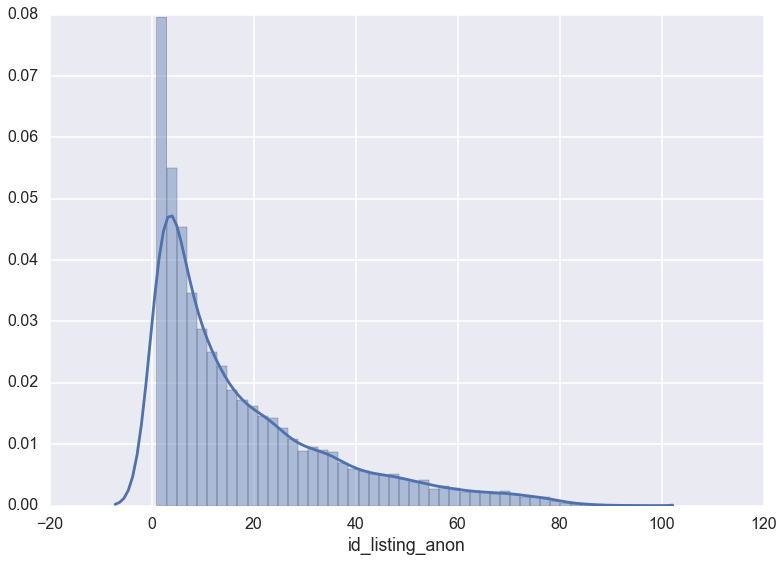

In [9]:
figure = plt.figure(figsize=(12, 10));
plt.figure();
p = sns.distplot(raw_data['id_listing_anon'].value_counts());

From the above plot, the number of unique listings in the dataset seems to be about 100. Also, the listings seem to follow a power law distribution which is expected. The more popular listings are booked often, are higher in demand and thus show up more number of times in the training dataset.

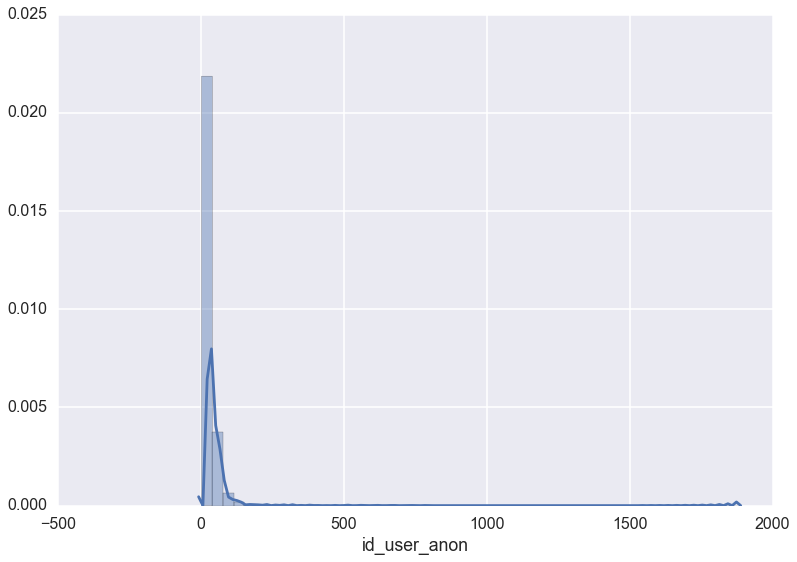

In [10]:
plt.figure()
p = sns.distplot(raw_data['id_user_anon'].value_counts());

The distribution of users seems more skewed as compared to listings which implies that there are few users with quite a few listings that are very popular and get booked over and over again. The rest of the users form the very long tail of the user distribution and contribute to a single listing. The former type of users seem to be vacation rental owners whose primary occupation is to manage and rent out vacation homes. The latter type of users usually are people who have an extra free room that they want to rent out for financial rewards. 

A somewhat surprising observation from the above dataset is that there seems to be more number of unique users or listing hosts (about 2000) compared to the number of unique listings (about 100). This implies each unique listing is connected to more than one unique host. This could possibly happen when an user created an account and listed his/her home and at a later point of time forgot about the account and created another one to advertise the same listing.

It might be useful to periodically check accounts that were inactive for a prolonged period of time and remove them if a duplicate account has been identified (possibly after sending a note to the account holder).

Paris            113704
Los Angeles       52698
San Francisco     17877
Name: dim_market, dtype: int64


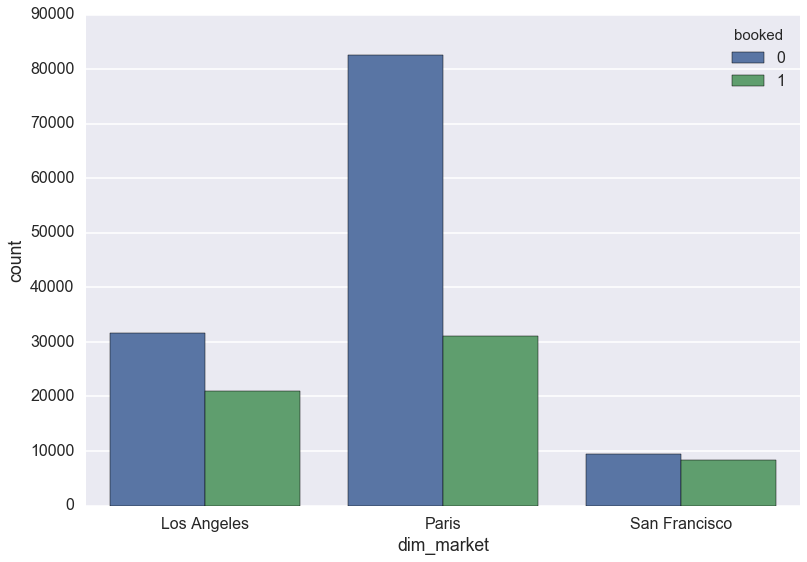

In [11]:
print raw_data['dim_market'].value_counts()
plt.figure()
sns.countplot(x="dim_market", hue="booked", data=raw_data);

Overall, Paris accounts for twice as many data points as Los Angeles and about 10 times as compared to San Francisco. It is interesting to note that the target variable has a remarkably different distribution for different marketplaces. It is roughly balanced for San Francisco but highly skewed for Paris. We will revisit this aspect again towards the end of this report.

Entire home/apt    129885
Private room        47546
Shared room          6848
Name: dim_room_type, dtype: int64


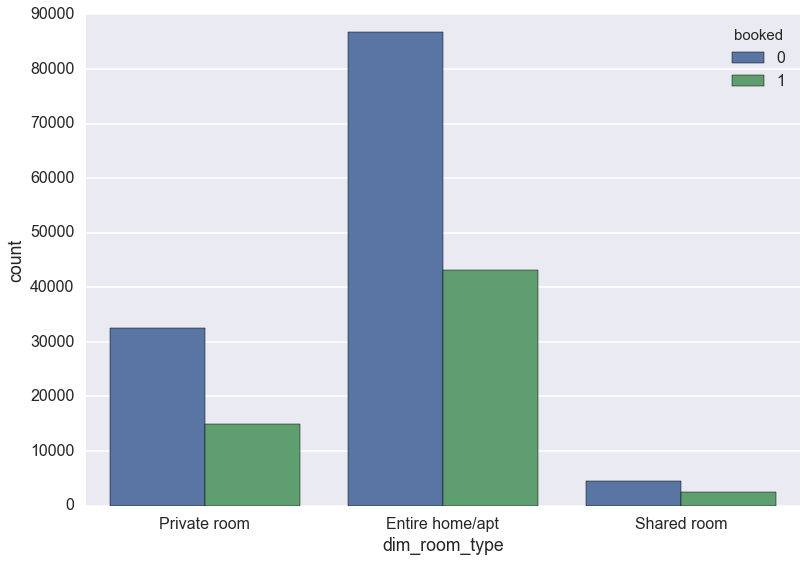

In [12]:
print raw_data['dim_room_type'].value_counts()
plt.figure()
sns.countplot(x="dim_room_type", hue="booked", data=raw_data);

In our dataset, most of the listings are for "Entire home/apt" and much less for "Shared room". The target variable distribution for each room-type is roughly similar and seems close to a 2:1 ratio in favor of the negative label (booked=0 or no booking was requested for this listing).

False    157427
True      26852
Name: dim_is_instant_bookable, dtype: int64


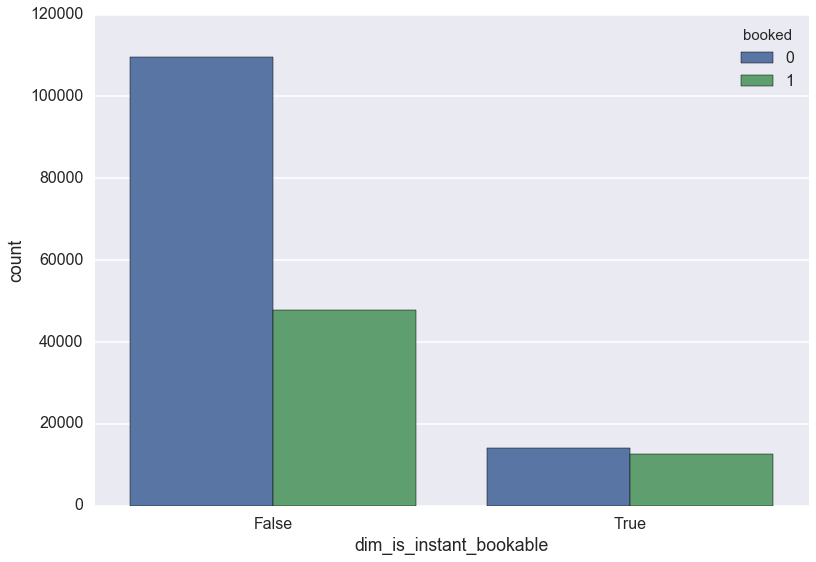

In [13]:
print raw_data['dim_is_instant_bookable'].value_counts()
plt.figure()
sns.countplot(x="dim_is_instant_bookable", hue="booked", data=raw_data);

Marking a listing as instantly bookable doesn't seems to be a strong signal for whether the listing would be actually booked. At this point, this feature seems not very informative. We will revisit this feature again when interpreting model feature weights.

## Understanding numerical features

### Missing numerical features

In [14]:
### check for missing values
stats = raw_data[numerical].describe()
numerical_cols_w_missing_values = [col for col in stats.columns if stats[col]['count']!=len(raw_data)]
print numerical_cols_w_missing_values
len(numerical_cols_w_missing_values)

['m_checkouts', 'm_reviews', 'days_since_last_booking', 'image_quality_score', 'm_total_overall_rating', 'm_professional_pictures', 'ds_checkin_gap', 'ds_checkout_gap', 'occ_occupancy_plus_minus_7_ds_night', 'occ_occupancy_plus_minus_14_ds_night', 'occ_occupancy_trailing_90_ds', 'm_minimum_nights', 'm_maximum_nights', 'price_booked_most_recent', 'p2_p3_click_through_score', 'p3_inquiry_score', 'listing_m_listing_views_2_6_ds_night_decay', 'r_kdt_listing_views_0_6_avg_n100', 'r_kdt_n_active_n100', 'r_kdt_n_available_n100', 'r_kdt_m_effective_daily_price_n100_p50', 'r_kdt_m_effective_daily_price_available_n100_p50', 'r_kdt_m_effective_daily_price_booked_n100_p50']


23

Among the 38 numerical columns, 23 columns have missing values. In order to fill the missing values, it would be useful to generate the boxplot of these features that would give us a sense of the distribution of feature values.

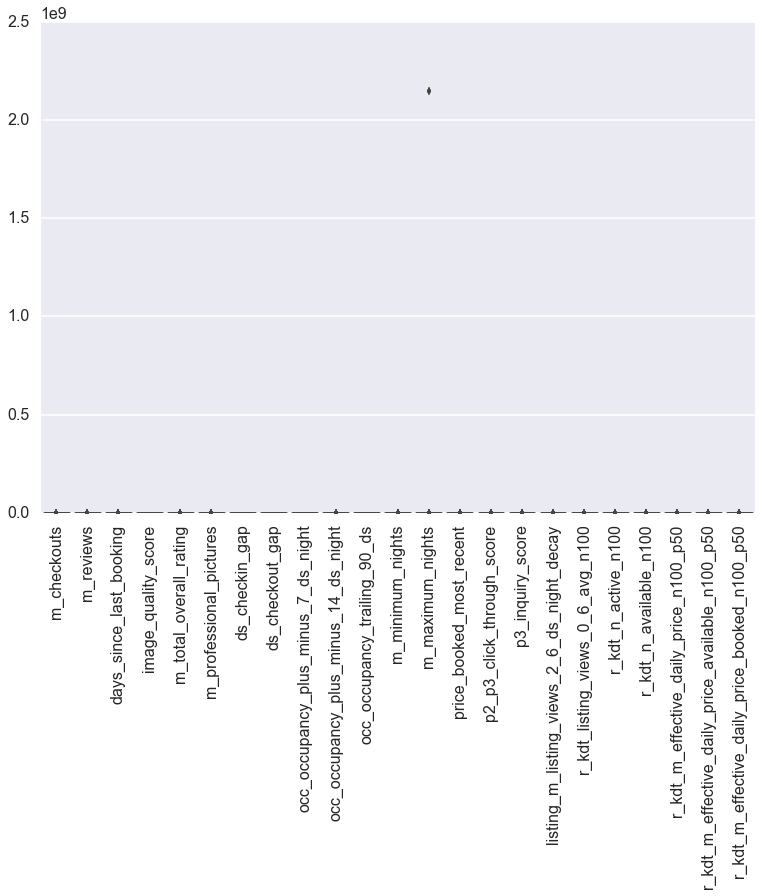

In [15]:
plt.figure()
ax = sns.boxplot(raw_data[numerical_cols_w_missing_values]);
ax.set_xticklabels(labels=numerical_cols_w_missing_values,rotation=90);

As can be seen from the above plot, the operating range of different features are quite different. For improved visualization purposes, we plan break them into multiple box plots based on their range of values.

At this point, we also note that the maximum value for 'm_maximum_nights' seems to be greater than 2 billion which seems like an erroneous value. We might likely drop these errorneous data points if they are two few.

In [16]:
print len(raw_data[raw_data['m_maximum_nights'] > 2500])
print len(raw_data[raw_data['m_maximum_nights'] > 365])

167
96151


The numbers show that about 167 samples have more than 2500 as values for 'm_maximum_nights' feature. One would think that a valid upper bound for this feature would be the number of days in a year, i.e., 365 but filtering on this threshold leads to removal of 96151 or roughly half of the dataset. So based on our preliminary analysis we settle for dropping only 167 data points.

In [17]:
raw_data = raw_data[raw_data['m_maximum_nights'] <= 2500]

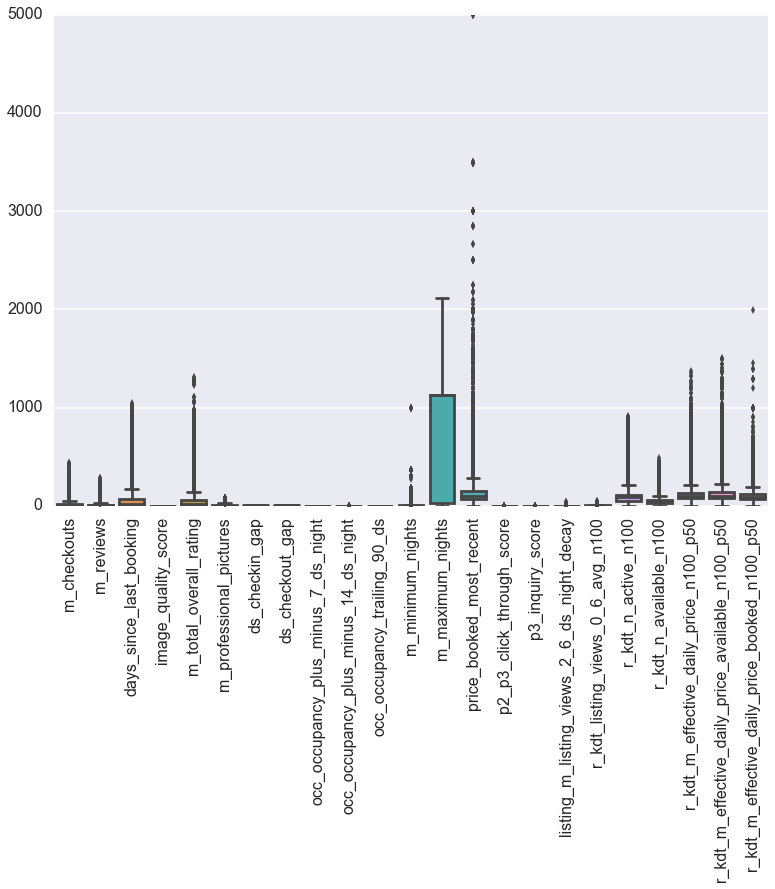

In [18]:
plt.figure()
ax = sns.boxplot(raw_data[numerical_cols_w_missing_values]);
ax.set_xticklabels(labels=numerical_cols_w_missing_values,rotation=90);

Now we observe that 'price_booked_most_recent' has a high value of $5000 which not completely reasonable. In the following we observe the quantiles of this feature.

In [19]:
print [raw_data['price_booked_most_recent'].quantile(x) for x in list([0.01,0.10,0.25,0.5,0.75,0.95,0.99])]

[nan, nan, nan, nan, nan, nan, nan]


As can be seen, only about 1% of values are at an extremely high value which is possible for exotic listings that are offered at an extraordinary high price. Hence we keep the values of this feature unchanged. 

However, the above box plot denotes that each variable has a very different value range. Hence, for model learning purposes it might be useful to scale them to an uniform range. We will refer to this again when training models.

Before we move on to other analysis we briefly look at distribution of all numerical columns and not just the ones with missing values.

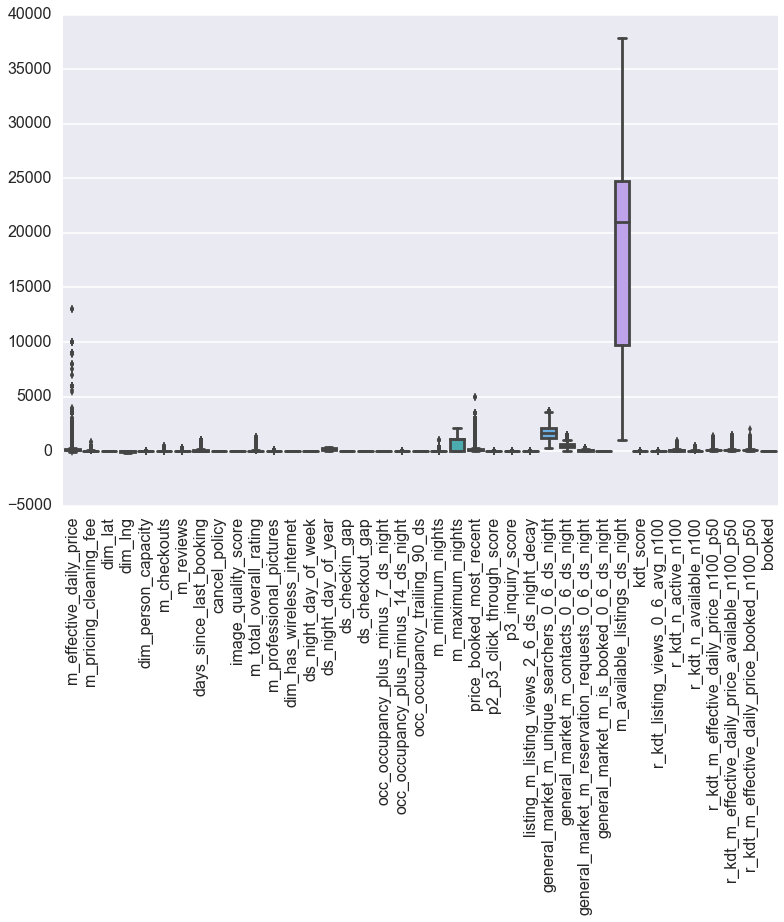

In [20]:
plt.figure()
ax = sns.boxplot(raw_data[numerical]);
ax.set_xticklabels(labels=numerical,rotation=90);

Once again, one of the features 'm_available_listings_ds_night' has a very high value the both the distribution and the range of values look realistic. We do note that now we see values appearing in negative range. We will spend the next few moments to take detailed look for sanity checking purposes.

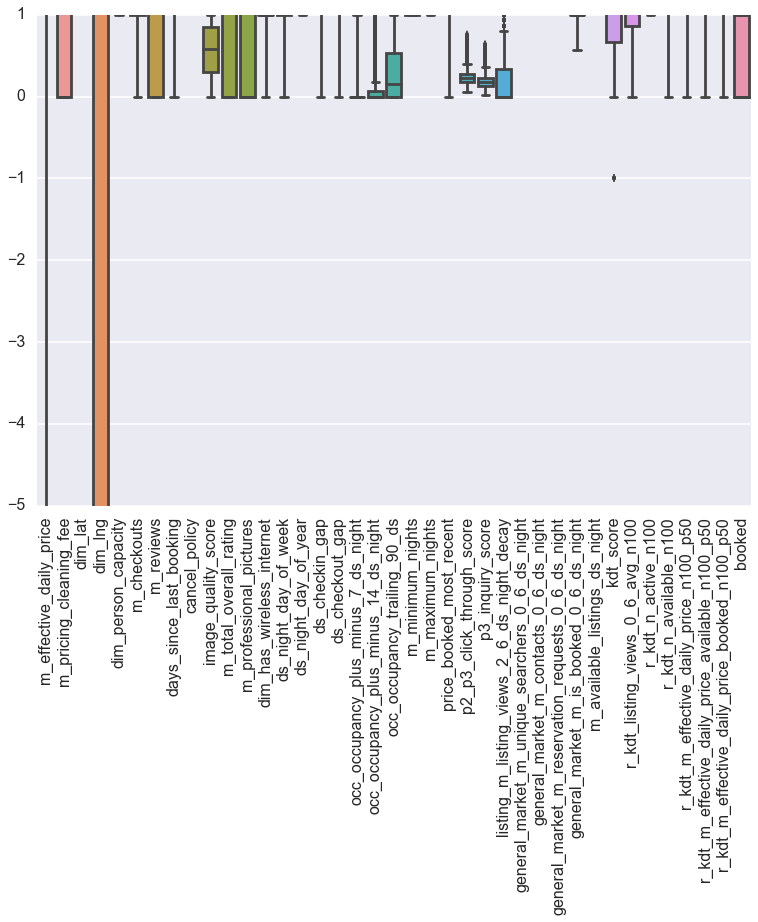

In [21]:
plt.figure()
ax = sns.boxplot(raw_data[numerical]);
ax.set(ylim=(-5,1));
ax.set_xticklabels(labels=numerical,rotation=90);

We observe that 'dim_long' is negative which is definitely possible. We also observe that 'kdt_score' has negative feature values. Although, we are unaware of how exactly the score is calculated, we do observe that almost all values for 'kdt_score' are more than 0 and only 6 samples have less than 0 values.

In [22]:
print len(raw_data[raw_data['kdt_score'] < 0])

6


So we will drop the samples with negative 'kdt_score' values.

In [23]:
raw_data = raw_data[raw_data['kdt_score'] >= 0]

In the interest of time, we will stop exploring the distribution of numerical values. After dropping a small number of samples where some of the feature values were very extreme, we can reasonably infer from our data distribution visualizations that the remaining data points lie within a reasonable range. However, since the distributions in most cases are not exactly symetric as seen in the box plots, we decied to impute the values for missing features with the median of the corresponding feature value, as follows.

In [24]:
for col in numerical:
    raw_data[col].fillna(raw_data[col].median(), inplace = True)

### Exploratory data analysis

As a final step of the data exploration section, we inspect the pairwise correlations between numerical features to account to inherent multi-collinearity in the dataset.

In [25]:
# Compute the correlation matrix
corr_full = raw_data[numerical].corr()
corr = corr_full.stack().order(ascending=False,kind="quicksort")
corr.drop_duplicates(keep='first',inplace='True')
corr = corr[corr.index.get_level_values(0) != corr.index.get_level_values(1)]

# display top and bottom k 
pd.set_option("display.max_rows",10)
print '\nMost correlated features'
print corr[0:10]
print '\nLeast correlated features'
print corr[-10:-1]
pd.set_option("display.max_rows",5)


Most correlated features
m_total_overall_rating                              m_reviews                                        0.99
dim_lat                                             dim_lng                                          0.99
r_kdt_m_effective_daily_price_available_n100_p50    r_kdt_m_effective_daily_price_n100_p50           0.98
m_checkouts                                         m_reviews                                        0.97
m_total_overall_rating                              m_checkouts                                      0.96
general_market_m_reservation_requests_0_6_ds_night  general_market_m_contacts_0_6_ds_night           0.96
r_kdt_n_available_n100                              r_kdt_n_active_n100                              0.94
general_market_m_reservation_requests_0_6_ds_night  general_market_m_unique_searchers_0_6_ds_night   0.93
general_market_m_unique_searchers_0_6_ds_night      general_market_m_contacts_0_6_ds_night           0.91
occ_occupancy_plus_m

Some features in the dataset are highly correlated. For example, 'm_total_overall_rating' and 'm_reviews' strong correlation sounds reasonable and implies that most of the visitors had a pleasant experience. Similarly, 'm_checkouts' is also highly correlated with 'm_reviews' implying that destinations that have high ratings and lots of reviews are also the popular ones.

# Part B: Data Cleaning

As part of data cleaning, we plan to perform the following processes:

* impute missing values (already done in the above section)
* for features with outliers, clip values to within a pre-specified range
* create a separate dataset with scaled/normazlied/standardized feature values
* cluster features to uncover group structure
* transform features to log-scale (or other scales) if required

The first step, i.e., missing feature value imputation has already been achieved in the previous section. The following tasks such as clipping feature values to within a valid range or scaling and normalizing them would be taken care within the scikit based machine learning pipelines that we will see in a moment. For the same reasons, we refrain from any feature value transformations such as log transformations, etc.

Finally, clustering is an unsupervised technique to uncover hidden structures in data. However, the current dataset already contains geographical cluster information as features in form of kd-tree based attributes. At this point it is unclear if we need any additional clustering and, in the interest of time, we decided to keep only the kd-tree based clustering and revisit this aspect at a later point of time, if required. Now we will move on to the modeling section.

# Part C: Modeling

In this section, we plan to achieve the following:

Data preparation:

* decide what columns are to be used as features and labels

* perform encoding of categorical variables (via one-hot or ordinal encoding) if required

* decide whether to scale (and normalize) data prior to applying models

Modeling:

* pick a few models from a standard machine learning library (scikit-learn)

* decide on train/test split

* perform CV to pick the best parameters

* evaluate performance on test data

* pick one final model (or an ensemble thereof)

* generate a series of accuracy metrics to test the model from multiple angles

## Modeling Data Preparation
We model our setting as a classification problem where the goal is to predict the target variable 'dim_is_requested'. We derive an 0/1 attribute from 'dim_is_requested' and name it 'booked'. The rest of the attributes in the dataset (with the exception of a few that were dropped earlier in the analysis, such as, 'ds_night') are used as features for training the model.

The dataset in its current form contains a mix of numerical and categorical features. Our machine learning library of choice (scikit-learn) cannot handle categorical features and requires them to be converted to numerical values via either one-hot or ordinal encoding. Since ordinal encoding imposes an order on the different categories or feature values and this ordering need not be necessarily true, we decide to go with one-hot encoding. However, one-hot encoding has the disadvantage that if the dataset contains features with high cardinality (which in our case are features 'id_listing_anon' and 'id_user_anon') then the final dimensionality of the dataset could be very high. Very high dimensionality could lead to problems such as overfitting as well as might also require higher compute resources in terms of memory and time.

In order to stay within the time limit constraints of this exercise, we choose to not use the features 'id_listing_anon' and 'id_user_anon'. We will train a model without these features and plan to revisit these features at a latter point and use them to improve model performance, if required.

Our categorical attributes are:
```python
categorical = ['dim_is_requested', 'ds_night', 'ds', 
               'id_listing_anon', 'id_user_anon', 'dim_market', 
               'dim_room_type', 'dim_is_instant_bookable']
```
The first attribute 'dim_is_requested' (or the label 'booked' derived from it) is used as the target. The second and third attributes are essentially the same and vary only by an additive constant (of 30). In addition, 'ds_night' or 'ds' is already encoded in other attributes such as 'ds_night_day_of_year' and 'ds_night_week_of_year'. So to avoid colinearity to the extent possible we decide to not use the features 'ds_night' and 'ds'. 

In the following, we only encode the features 'id_listing_anon', 'id_user_anon', 'dim_is_instant_bookable', 'dim_market', 'dim_room_type' where the first three are encoded using ordinal encoding and the last three via one-hot encoding due to reasons mentioned earlier.

In [26]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

modeling_data = pd.DataFrame()

# Copy all numerical data
modeling_data[numerical] = raw_data[numerical]
modeling_data.head()

# these are our categorical attributes
# categorical = ['dim_is_requested', 'ds_night', 'ds', 'id_listing_anon', \
#                'id_user_anon', 'dim_market', 'dim_room_type', 'dim_is_instant_bookable']
#
# Encode all non-numerical variables
modeling_data['id_listing_anon'] = le.fit_transform(raw_data['id_listing_anon'])
modeling_data['id_user_anon'] = le.fit_transform(raw_data['id_user_anon'])
modeling_data['dim_is_instant_bookable'] = le.fit_transform(raw_data['dim_is_instant_bookable'])

modeling_data['id_listing_anon'] = modeling_data['id_listing_anon'].apply(lambda x: 'LID='+str(x))
modeling_data['id_user_anon'] = modeling_data['id_user_anon'].apply(lambda x: 'UID='+str(x))
modeling_data['dim_market'] = raw_data['dim_market'].apply(lambda x: 'MKT='+filter(str.isupper,x))
modeling_data['dim_room_type'] = raw_data['dim_room_type'].apply(lambda x: 'RTP='+x.replace(' ','_').replace('/','_'))

In [27]:
modeling_data = modeling_data.drop(['id_listing_anon','id_user_anon'],axis=1)
modeling_data_w_dummies = pd.get_dummies(modeling_data, columns = ['dim_market','dim_room_type'])

modeling_data_w_dummies.head()

,m_effective_daily_price,m_pricing_cleaning_fee,...,dim_room_type_RTP=Private_room,dim_room_type_RTP=Shared_room
0,110.00,60.00,...,1.00,0.00
1,70.00,0.00,...,1.00,0.00
2,125.00,0.00,...,1.00,0.00
3,126.87,125.00,...,0.00,0.00
4,210.71,200.00,...,0.00,0.00


In [28]:
featCols = modeling_data_w_dummies.drop(['booked'], axis=1)
labelCol = modeling_data_w_dummies['booked'] 

features = featCols
labels = labelCol
print 100.0 * labels.sum()/labels.count()

32.7179261621


We note that if a model blindly predicts '0' (or 'Not Booked') for all samples in our dataset, then it would be able to achieve an accuracy (= (true positives+true negatives)/num samples)) of (100-32.717)=67.28%. Hence we note that accuracy as defined above is not a good metric for evaluating the models on this dataset. For this reason, in the model evaluation section, we will use evaluation metrics other than 'accuracy'.

## Model training
Since the above data is a mixture of categorical and nominal values, we first apply tree based models on the dataset. In order to leverage the power of ensemble models we start with Random Forest and Gradient Boosted Machines. However, in order to compare with some baseline approaches, we will also train a Logisitic Regression classifier.

For almost all cases we will only marginally deviate from the default parameters.

Also, we start the modeling process with an usual 80:20 split of the data into training and testing, respectively.

In [29]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.learning_curve import learning_curve;
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, roc_curve, log_loss
from sklearn.pipeline import Pipeline

/Users/avishek2/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/avishek2/anaconda2/lib/python2.7/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [30]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2)
standard_scaler = StandardScaler()

log_l = Pipeline([('scaler',standard_scaler), ('lr', LogisticRegression(C=1e4))]);
ran_l = Pipeline([('scaler',standard_scaler), ('rf', RandomForestClassifier(n_estimators=100,n_jobs=-1))]);
gbm_l = Pipeline([('scaler', standard_scaler), ('gbm', GradientBoostingClassifier(n_estimators=100))]);
classifiers = [
    ('LogReg Linear', log_l),
    ('RanFor Linear', ran_l),
    ('GBM Linear', gbm_l)
];

In [31]:
tr_precisions, tr_recalls, tr_aucs, tr_nlls = [], [], [], []
te_precisions, te_recalls, te_aucs, te_nlls = [], [], [], []

for (name, clf) in classifiers:
    print 'Training', name, '...'
    clf.fit(X_train, y_train);
    
    # training metrics
    y_pred = clf.predict(X_train);
    try:
        y_score = clf.predict_proba(X_train)[:,1];
    except AttributeError, e:
        y_score = clf.decision_function(X_train);
    tr_precisions.append(precision_score(y_train, y_pred));
    tr_recalls.append(recall_score(y_train, y_pred));
    tr_aucs.append(roc_auc_score(y_train, y_score));
    tr_nlls.append(log_loss(y_train, y_pred));
    
    # testing metrics
    y_pred = clf.predict(X_test);
    try:
        y_score = clf.predict_proba(X_test)[:,1];
    except AttributeError, e:
        y_score = clf.decision_function(X_test);
    te_precisions.append(precision_score(y_test, y_pred));
    te_recalls.append(recall_score(y_test, y_pred));
    te_aucs.append(roc_auc_score(y_test, y_score));
    te_nlls.append(log_loss(y_test, y_pred));

print 'Done'

Training LogReg Linear ...
Training RanFor Linear ...
Training GBM Linear ...
Done


## Model Evaluation

In [32]:
pd.set_option('precision',4)
pd.set_option('float_format', '{:.4f}'.format)

print 'Train Metrics'
print pd.DataFrame({'Precision': tr_precisions, 'Recall': tr_recalls, 'AUC': tr_aucs, 'NLL': tr_nlls},
                       columns='Precision Recall AUC NLL'.split(),
                       index=map(lambda (x,y): x, classifiers))

print '\nTest Metrics'
print pd.DataFrame({'Precision': te_precisions, 'Recall': te_recalls, 'AUC': te_aucs, 'NLL': te_nlls},
                       columns='Precision Recall AUC NLL'.split(),
                       index=map(lambda (x,y): x, classifiers))

Train Metrics
               Precision  Recall    AUC    NLL
LogReg Linear     0.7083  0.5401 0.8340 7.7123
RanFor Linear     1.0000  0.9999 1.0000 0.0009
GBM Linear        0.7433  0.6159 0.8704 6.7455

Test Metrics
               Precision  Recall    AUC    NLL
LogReg Linear     0.7075  0.5402 0.8383 7.7145
RanFor Linear     0.8093  0.7228 0.9216 5.0541
GBM Linear        0.7424  0.6131 0.8691 6.7717


At this point, we note one can further improve the classfier performance by throwing in quadratic features. However, the higher order feature expectedly take more time and hence we couldn't get to sufficiently play with them within the time constraints of this take home exercise.

Random Forest substantially outperforms the other two classifiers on all of the above model evaluation measures. As we had seen above, the dataset has quite a few features that are highly correlated. The Random Forest algorithms picks features in a manner to so as to decorrelate the trees, thus implicitly tackling issues that might arise from aforementioned multicollinearity.

### AUC-ROC Curve
AUC is a global number over all decision thresholds which fails to present a finer picture of what TPR and FPR values look like at individual thresholds. To that end, we will spend some time inspecting the AUC-ROC curves for the above classifiers.

Training LogReg Linear ...
Training RanFor Linear ...
Training GBM Linear ...
Done


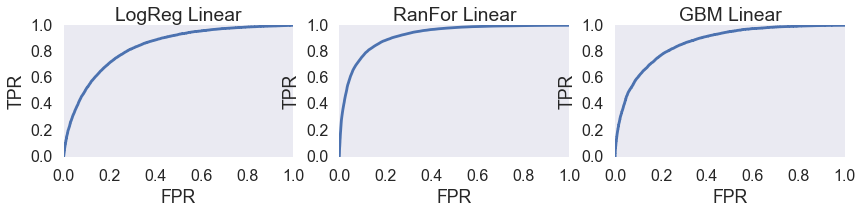

In [33]:
log_l = Pipeline([('scaler',standard_scaler), ('lr', LogisticRegression(C=1e4))])
ran_l = Pipeline([('scaler',standard_scaler), ('rf', RandomForestClassifier(n_estimators=100,n_jobs=-1))])
gbm_l = Pipeline([('scaler', standard_scaler), ('gbm', GradientBoostingClassifier(n_estimators=100))])
classifiers = [
    ('LogReg Linear', log_l),
    ('RanFor Linear', ran_l),
    ('GBM Linear', gbm_l)
]

figure = plt.figure(figsize=(14, 8))

k = 0
for (name, clf) in classifiers:
    print "Training", name, "..."
    clf.fit(X_train, y_train);
    y_pred = clf.predict(X_test)
    try:
        y_score = clf.predict_proba(X_test)[:,1]
    except AttributeError, e:
        y_score = clf.decision_function(X_test)
    
    fpr, tpr, _ = roc_curve(y_test, y_score);
    
    sns.set_style("darkgrid")
    ax = plt.subplot(3, 3, k+1);
    plt.plot(fpr, tpr);
    #plt.title('AUC-ROC Curve for ' + name)
    plt.title(name);
    plt.xlabel('FPR');
    plt.ylabel('TPR');
    
    k += 1
    plt.grid();
    
print 'Done'

For AUC-ROC Curve, the top-left portion of the curve is the good region. As can be seen, Random Forest has reached the top-left region for very low values of FPR. This further reinforces the superior performance of Random Forest on this dataset.

### Learning curve


Training LogReg Linear ...

Training RanFor Linear ...

Training GBM Linear ...
Done


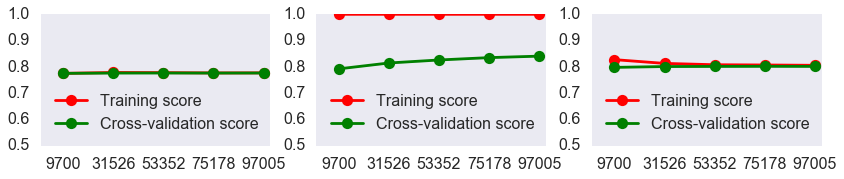

In [34]:
log_l = Pipeline([('scaler',standard_scaler), ('lr', LogisticRegression(C=1e4))])
ran_l = Pipeline([('scaler',standard_scaler), ('rf', RandomForestClassifier(n_estimators=100,n_jobs=-1))])
gbm_l = Pipeline([('scaler', standard_scaler), ('gbm', GradientBoostingClassifier(n_estimators=100))])
classifiers = [
    ('LogReg Linear', log_l),
    ('RanFor Linear', ran_l),
    ('GBM Linear', gbm_l)
]


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, 
                        train_sizes=np.linspace(.1, 1.0, 5),ax=None):
    from sklearn.learning_curve import learning_curve
    
    if ylim is not None:
        plt.ylim(*ylim)
    
    train_sizes, train_scores, test_scores = learning_curve(
            estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, 
                     alpha=0.1, color="r");
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, 
                     alpha=0.1, color="g");
    plt.plot(train_sizes, train_scores_mean, 
             'o-', color="r",label="Training score");
    plt.plot(train_sizes, test_scores_mean, 
             'o-', color="g",label="Cross-validation score");
    plt.legend(loc="best");
    
    ax.set_ylim(0.5,1);
    #ax.set_xticklabels(max(train_sizes)*np.linspace(.1, 1.0, 5))
    ax.set_xticks(train_sizes);
    
    return plt


### main
figure = plt.figure(figsize=(14, 8))
k = 0
for (name, clf) in classifiers:
    print '\nTraining', name, "..."
    ax = plt.subplot(3, 3, k+1)
    plot_learning_curve(clf,name,X_train,y_train,n_jobs=-1,ax=ax)
    k += 1
    
print 'Done'

Once again Random Forest stands out among others. From the nature of the cross-validation score, it seems like more data would likely further improve the Random Forest model accuracy.

### Confusion Matrix
Finally, we would like to see a summary of the models in terms of true predictions and false alarms. Confusion matrix is a good way to summarize this aspect of the model performance.

In [35]:
log_l = Pipeline([('scaler',standard_scaler), ('lr', LogisticRegression(C=1e4))])
ran_l = Pipeline([('scaler',standard_scaler), ('rf', RandomForestClassifier(n_estimators=100,n_jobs=-1))])
gbm_l = Pipeline([('scaler', standard_scaler), ('gbm', GradientBoostingClassifier(n_estimators=100))])
classifiers = [
    ('LogReg Linear', log_l),
    ('RanFor Linear', ran_l),
    ('GBM Linear', gbm_l)
]

for (name, clf) in classifiers:
    print '\nTraining', name, "..."
    clf.fit(X_train, y_train);
    y_pred = clf.predict(X_test)
    try:
        y_score = clf.predict_proba(X_test)[:,1]
    except AttributeError, e:
        y_score = clf.decision_function(X_test)
    
    m = confusion_matrix(y_test, y_pred)
    print 'Confusion Matrix'
    print pd.DataFrame(m, columns=['Predicted_Not_Booked', 'Predicted_Booked'], index = ['Not_Booked','Booked'])

print 'Done'


Training LogReg Linear ...
Confusion Matrix
            Predicted_Not_Booked  Predicted_Booked
Not_Booked                 21827              2656
Booked                      5469              6425

Training RanFor Linear ...
Confusion Matrix
            Predicted_Not_Booked  Predicted_Booked
Not_Booked                 22490              1993
Booked                      3262              8632

Training GBM Linear ...
Confusion Matrix
            Predicted_Not_Booked  Predicted_Booked
Not_Booked                 21953              2530
Booked                      4602              7292
Done


Once again, Random Forest outperforms its counterparts in terms of highest TP (true positives). The TN (true negative) are more or less similar across different baselines with Random Forest being slightly better than its counterparts.

Note: For our use case of booking prediction, the model should be more mindful towards reducing FPs (False Positives) than FNs (False Negatives). False Negatives imply that the model falsely predicted that a listing will not be booked and in such a scenario the listing host might consider reducing the listing price to ensure that the listing gets booked. If the model's negative prediction is false, then the listing would have gotten booked anyways and the listing host taking these extra steps would further increase the likelihood the listing getting booked. However, False Positives predictions from the model give the listing host a false belief that his/her listing will get booked and in the event that the listing doesn't get booked (because the model's positive prediction was false anyways), the host might loose business and the company will loose both business as well as the host's trust in its predictions. 

Fortunately, the Random Forest model reduces both FP and FN as compared to other baselines. 

Also, at this point we note that since Random Forest is already performing extremely well on training as well as test datasets, we will not spend any further effort in model selection via cross-validation based model parameter tuning or other similar approaches.

## Model Improvements
Going forward, we pick Random Forest as our model of choice and spend some time and effort to further improve the model performance. Two straight-forward ways to improve the model accuracy is to add richer features and to tune model parameters. Usually they go hand-in-hand because introducing too many new features into the model might lead the model to overfit wherein one has to tune the regularization parameter. In the following, we add new features (via quadratic interaction features) as well as tune the model parameters. Our Random Forest model with no quadratic interaction features serves as strawman baseline.

Decision Tree and its derivatives (such as GBDT and Random Forest) by design are able to capture non-linearity in the dataset. So adding all possible interaction features to such models might not greatly improve their performance out-of-the box. 

However, one can look at the predictions on the test data, slice it up along various attributed dimensions and do some micro-analysis on the metrics within each slice. The prime metric that would be of use in this regard would the differnece in actual and true predictions. Let us define "PredOverActual" as the ratio of number of bookings that were predicted by the model to the number of bookings that actually happended in the dataset. This ratio can be computed for any slice of the data (such as for various marketplaces) and a value of this ratio when close to '1' implies that the model is good at predictions. Values further off from 1 highlight issues with model quality. This analysis will give us additional insight as to which features to add and thus will guide our feature selection process.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2)
standard_scaler = StandardScaler()

ran_l = Pipeline([('scaler',standard_scaler), ('rf', RandomForestClassifier(n_estimators=100,n_jobs=-1))])
classifiers = [
    ('RanFor Linear', ran_l)
]


tr_precisions, tr_recalls, tr_aucs, tr_nlls = [], [], [], []
te_precisions, te_recalls, te_aucs, te_nlls = [], [], [], []


ran_l.fit(X_train, y_train);    
# training metrics
y_pred = ran_l.predict(X_train)
try:
    y_score = ran_l.predict_proba(X_train)[:,1]
except AttributeError, e:
    y_score = ran_l.decision_function(X_train)
tr_precisions.append(precision_score(y_train, y_pred))
tr_recalls.append(recall_score(y_train, y_pred))
tr_aucs.append(roc_auc_score(y_train, y_score))
tr_nlls.append(log_loss(y_train, y_pred))

# testing metrics
y_pred = ran_l.predict(X_test)
try:
    y_score = ran_l.predict_proba(X_test)[:,1]
except AttributeError, e:
    y_score = ran_l.decision_function(X_test)
te_precisions.append(precision_score(y_test, y_pred))
te_recalls.append(recall_score(y_test, y_pred))
te_aucs.append(roc_auc_score(y_test, y_score))
te_nlls.append(log_loss(y_test, y_pred))
print 'Done'

print 'Train Metrics'
print pd.DataFrame({'Precision': tr_precisions, 'Recall': tr_recalls, 'AUC': tr_aucs, 'NLL': tr_nlls},
                       columns='Precision Recall AUC NLL'.split(),
                       index=map(lambda (x,y): x, classifiers))
print '\nTest Metrics'
print pd.DataFrame({'Precision': te_precisions, 'Recall': te_recalls, 'AUC': te_aucs, 'NLL': te_nlls},
                       columns='Precision Recall AUC NLL'.split(),
                       index=map(lambda (x,y): x, classifiers))

Done
Train Metrics
               Precision  Recall    AUC    NLL
RanFor Linear     1.0000  1.0000 1.0000 0.0000

Test Metrics
               Precision  Recall    AUC    NLL
RanFor Linear     0.8055  0.7257 0.9204 5.0417


Let us now group data into a slice which we think would be useful. We hypothesize that the nature of booking very much depends upon a combination of the time of year and listing location. For example, during certain events of the year, people would like to flock to certain places. Although the above is not true for particularly popular destinations as we have in our dataset, let's move forward and check whether the above hypotheis is true.

In [37]:
pd.set_option("display.max_rows",12)

y_pred_df = pd.DataFrame({'Pred': y_pred},index=X_test.index)
modeling_data_w_pred = pd.concat([X_test,y_test,y_pred_df], axis=1)
modeling_data_w_pred['ds_night_month_of_year'] = np.floor(modeling_data['ds_night_day_of_year'] / 31)

print '\nLos Angeles'
modeling_data_w_pred_filterd = modeling_data_w_pred[modeling_data_w_pred['dim_market_MKT=LA'] == 1]
grouped = modeling_data_w_pred_filterd.groupby(['ds_night_month_of_year','dim_market_MKT=LA'])
grouped_agg = grouped.agg({'booked': 'sum', 'Pred': 'sum'})
grouped_agg['PredOverActual'] = grouped_agg['Pred'] / grouped_agg['booked']
print grouped_agg

print '\nParis'
modeling_data_w_pred_filterd = modeling_data_w_pred[modeling_data_w_pred['dim_market_MKT=P'] == 1]
grouped = modeling_data_w_pred_filterd.groupby(['ds_night_month_of_year','dim_market_MKT=P'])
grouped_agg = grouped.agg({'booked': 'sum', 'Pred': 'sum'})
grouped_agg['PredOverActual'] = grouped_agg['Pred'] / grouped_agg['booked']
print grouped_agg

print '\nSan Francisco'
modeling_data_w_pred_filterd = modeling_data_w_pred[modeling_data_w_pred['dim_market_MKT=SF'] == 1]
grouped = modeling_data_w_pred_filterd.groupby(['ds_night_month_of_year','dim_market_MKT=SF'])
grouped_agg = grouped.agg({'booked': 'sum', 'Pred': 'sum'})
grouped_agg['PredOverActual'] = grouped_agg['Pred'] / grouped_agg['booked']
print grouped_agg


Los Angeles
                                          Pred  booked  PredOverActual
ds_night_month_of_year dim_market_MKT=LA                              
0.0000                 1.0000              293     294          0.9966
1.0000                 1.0000              326     332          0.9819
2.0000                 1.0000              363     367          0.9891
3.0000                 1.0000              347     344          1.0087
4.0000                 1.0000              354     343          1.0321
5.0000                 1.0000              379     373          1.0161
6.0000                 1.0000              416     403          1.0323
7.0000                 1.0000              391     362          1.0801
8.0000                 1.0000              368     359          1.0251
9.0000                 1.0000              371     364          1.0192
10.0000                1.0000              315     322          0.9783
11.0000                1.0000              232     245          

In the above analysis, we propose a new slice that is a combination of 'ds_night_month_of_year' and 'dim_market'. The hypothesis is that different markets experience different demand surge depending upon seasonal events and 'ds_night_day_of_year' is too granular to capture that just by itself. 

This claim can be evidenced by our analysis above where we compute the ratio of the predicted bookings to actual bookings for different months of the year and based on different markets. A ratio close to 1 implies the model is doing a reasonably good job. For LA, the model predictions are fairly close expect the first and last month of the year. The model also predicts reasonably well for the SF market. However for Paris, the model prediction substantially low throughout the year. 

In [ ]:
modeling_data_w_conjs = pd.DataFrame()
modeling_data['month__mkt'] = (modeling_data['ds_night_day_of_year'] / 31).astype(str) + \
                                '__' + \
                                modeling_data['dim_market'].astype(str) 

modeling_data_w_conjs = pd.get_dummies(modeling_data, columns = ['dim_market','dim_room_type','month__mkt'])


featCols = modeling_data_w_conjs.drop(['booked'], axis=1)
labelCol = modeling_data_w_conjs['booked'] ### Note this needs to be a list and not single index
features = featCols
labels = labelCol


X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2)
standard_scaler = StandardScaler()

ran_l = Pipeline([('scaler',standard_scaler), ('rf', RandomForestClassifier(n_estimators=100,n_jobs=-1))])
classifiers = [
    ('RanFor Linear', ran_l)
]

tr_precisions, tr_recalls, tr_aucs, tr_nlls = [], [], [], []
te_precisions, te_recalls, te_aucs, te_nlls = [], [], [], []

for (name, clf) in classifiers:
    print '\nTraining', name, '...'
    clf.fit(X_train, y_train)
    
    # training metrics
    y_pred = clf.predict(X_train)
    try:
        y_score = clf.predict_proba(X_train)[:,1]
    except AttributeError, e:
        y_score = clf.decision_function(X_train)
    tr_precisions.append(precision_score(y_train, y_pred))
    tr_recalls.append(recall_score(y_train, y_pred))
    tr_aucs.append(roc_auc_score(y_train, y_score))
    tr_nlls.append(log_loss(y_train, y_pred))
    
    # testing metrics
    y_pred = clf.predict(X_test)
    try:
        y_score = clf.predict_proba(X_test)[:,1]
    except AttributeError, e:
        y_score = clf.decision_function(X_test)
    te_precisions.append(precision_score(y_test, y_pred))
    te_recalls.append(recall_score(y_test, y_pred))
    te_aucs.append(roc_auc_score(y_test, y_score))
    te_nlls.append(log_loss(y_test, y_pred))

print 'Done'


print 'Train Metrics'
print pd.DataFrame({'Precision': tr_precisions, 'Recall': tr_recalls, 'AUC': tr_aucs, 'NLL': tr_nlls},
                       columns='Precision Recall AUC NLL'.split(),
                       index=map(lambda (x,y): x, classifiers))
print '\nTest Metrics'
print pd.DataFrame({'Precision': te_precisions, 'Recall': te_recalls, 'AUC': te_aucs, 'NLL': te_nlls},
                       columns='Precision Recall AUC NLL'.split(),
                       index=map(lambda (x,y): x, classifiers))

In [39]:
y_pred_df = pd.DataFrame({'Pred': y_pred},index=X_test.index)
modeling_data_w_pred = pd.concat([X_test,y_test,y_pred_df], axis=1)
modeling_data_w_pred['ds_night_month_of_year'] = np.floor(modeling_data['ds_night_day_of_year'] / 31)

print '\nLos Angeles'
modeling_data_w_pred_filterd = modeling_data_w_pred[modeling_data_w_pred['dim_market_MKT=LA'] == 1]
grouped = modeling_data_w_pred_filterd.groupby(['ds_night_month_of_year','dim_market_MKT=LA'])
grouped_agg = grouped.agg({'booked': 'sum', 'Pred': 'sum'})
grouped_agg['PredOverActual'] = grouped_agg['Pred'] / grouped_agg['booked']
print grouped_agg

print '\nParis'
modeling_data_w_pred_filterd = modeling_data_w_pred[modeling_data_w_pred['dim_market_MKT=P'] == 1]
grouped = modeling_data_w_pred_filterd.groupby(['ds_night_month_of_year','dim_market_MKT=P'])
grouped_agg = grouped.agg({'booked': 'sum', 'Pred': 'sum'})
grouped_agg['PredOverActual'] = grouped_agg['Pred'] / grouped_agg['booked']
print grouped_agg

print '\nSan Francisco'
modeling_data_w_pred_filterd = modeling_data_w_pred[modeling_data_w_pred['dim_market_MKT=SF'] == 1]
grouped = modeling_data_w_pred_filterd.groupby(['ds_night_month_of_year','dim_market_MKT=SF'])
grouped_agg = grouped.agg({'booked': 'sum', 'Pred': 'sum'})
grouped_agg['PredOverActual'] = grouped_agg['Pred'] / grouped_agg['booked']
print grouped_agg


Los Angeles
                                          Pred  booked  PredOverActual
ds_night_month_of_year dim_market_MKT=LA                              
0.0000                 1.0000              251     275          0.9127
1.0000                 1.0000              352     372          0.9462
2.0000                 1.0000              332     354          0.9379
3.0000                 1.0000              357     340          1.0500
4.0000                 1.0000              314     334          0.9401
5.0000                 1.0000              379     357          1.0616
6.0000                 1.0000              411     398          1.0327
7.0000                 1.0000              391     358          1.0922
8.0000                 1.0000              411     399          1.0301
9.0000                 1.0000              385     387          0.9948
10.0000                1.0000              314     324          0.9691
11.0000                1.0000              220     237          

As we can see, the introduction of additional conjunction didn't greatly improve the model. Surely there must be other useful features that need to be introduced. A follow up hypothesis is that the listings are so unique, one might consider modeling them separaretely for each market place. An useful feature in that direction is the conjunction of 'id_listing_anon' with 'dim_market'. For example,
```python
modeling_data['listing__mkt'] = 
    modeling_data['id_listing_anon'].astype(str) + \
    '__' + \
    modeling_data['dim_market'].astype(str) 
```
We tried this conjunction but couldn't obtain the end results of the modeling since the time taken to encode the feature was somewhat large that rendered my test machine out-of-memory. But on a bigger machine with more compute resources, the conjunction is definitely worth a try.

We also conjecture using our slicing of dimensions recipe, one can come up with a series of useful features and some of those could be critical in improving model effectiveness.

# Part D: Recommendations

## Feature Importances

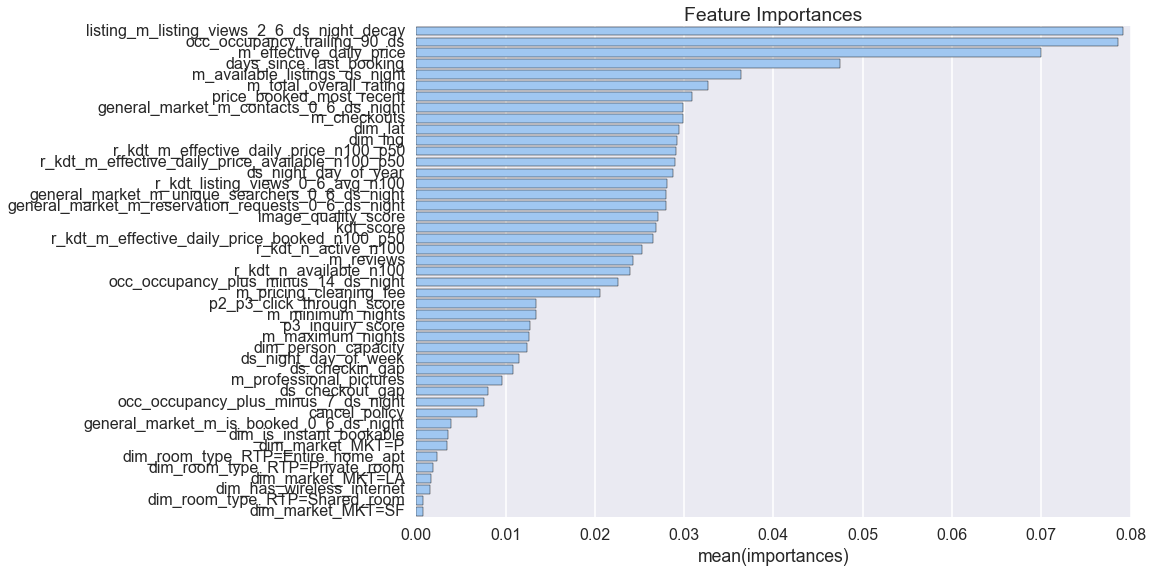

In [40]:
# reverting to the older dataset without feature conjunctions
featCols = modeling_data_w_dummies.drop(['booked'], axis=1)
labelCol = modeling_data_w_dummies['booked'] 
features = featCols
labels = labelCol
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2)
standard_scaler = StandardScaler()

ran_l = Pipeline([('scaler',standard_scaler), ('rf', RandomForestClassifier(n_estimators=100,n_jobs=-1))])

ran_l.fit(X_train, y_train)

feat_imps = pd.DataFrame({'importances':ran_l.named_steps['rf'].feature_importances_}, index=features.columns)
feat_imps_sorted = feat_imps.sort_values(by='importances',ascending=False)

figure = plt.figure(figsize=(12, 10));
plt.figure();
plt.title('Feature Importances');
sns.set_color_codes("pastel");
sns.barplot(x="importances", y=feat_imps_sorted.index, data=feat_imps_sorted, label="Feature importances", color="b");
ax.legend(ncol=2, loc="lower right", frameon=True);
sns.despine(left=True, bottom=True);

Based on the modeling results and the observed feature ranks, one can infer the following insights:

* Feature 'listing_m_listing_views_2_6_ds_night_decay' is the most predictive which is expected because the number of views in the past few days is a direct indicator of the interest level in that particular listing.

* Features 'occ_occupancy_trailing_90_ds' and 'm_effective_daily_price' are the next most predictive features which intuitively make sense. Popular listings will be sought after everyone and hence likely will have a higher average occupancy rate; they also will likley receive more requests to be booked. The daily effective price is a culmination of multiple properties (like location, decor, uniqueness) of the listing and is a good indicator of the listing's chances to be booked.

* Quite expectedly, the model implies that feature 'market' is not very discriminative. While location of listings are strong indicators of booking probability, we might conclude that for this particular datasets, the location is not a very discriminative features. All three locations are highly popular as tourist destinations and thus by themselves are not informative enough, as per the model.

* Somewhat surprising, the model points out that 'professional_pictures' don't improve the chances of a listing getting booked. One could contend that this possibly is an artifact of the dataset provided. In order completely verify this hypothesis one needs to test of a wider variety of datasets. There could also be confounding factors such as location (which in this case being highly popular destinations) that renders useless the need for good pictures. If indeed it turns out that 'professional_pictures' pictures do not help the probability of booking, then one might consider doing away with the extra cost associated with pictures taken by professional photographers.

* It is only natural that local listing features will have a strong influence on booking probability of a given listing. Nearby listings could provide price support and a lack thereof could drive up demand. No wonder 'r_kdt_m_effective_daily_price_n100_p50', 'r_kdt_m_effective_daily_price_available_n100_p50', and 'r_kdt_listing_views_0_6_avg_n100' features rank high in importance list.

* Another point to note is that 'dim_is_instant_bookable' does not seem to be a very informative feature. This is in agreement with our earlier findings when exploring categorical variables in Section A.

# Part E: Concluding thoughts

To recap, we started with data explorations. We separated out categorical features from numerical and looked at their
distribution. For numerical features we identified some extremities in their feature value distribution which lead us to drop those outliers from the data. We identified missing values within the numerical features wherein we imputed the missing feature values via the median value of the respective feature distribution. In addition, we inspected pairwise feature correlations among numerical features and noticed that quite a few
pair of features are highly correlated. An interesting outcome of the above analysis was that the number of unique hosts is much more than number of unique listings. We conjectured that this could be due to same host creating duplicate accounts to list the same property.

Thereafter we prepared the data for modeling starting with feature encoding of categorical features, and then generating train/test splits. On the modeling side, we experimented with a few different modeling paradigms, such as, linear models which primarily served as our baseline, and ensemble of non-linear models.  Among ensemble models, random forests were able to learn a perfect classifier on the training set and out-performed
other baselines on the test set as evidenced by our entire suite of evaluation metrics.

Next we aimed to improve the model peformance via intelligent design of new features guided by data analysis. Our new features where unable to significantly improve the model metrics. However, the proposed recipe can be used to infer new conjunctions which when repeatedly tested and applied could lead to improvements in modeling accuracy.

Finally, based on model performance as well importance value assigned to features by the model, we were able to glean some insights into the signals that are most informative when predicting the probability of a listing being booked. 

A few additional aspects that we would have liked to investigate, time permitting were:

* Feature value transformations (such as, log transformations) particularly so for features with a large dynamic range of values. Although we did scale features prior to modeling, a tranformation prior to scaling could be beneficial.

* Coding optimizations as in this notebook we are repeatedly training the same model for different evaluation metric analysis. One could possible train once and store it in a state variable and then reuse the stored model co-efficients and predictions over and over again. Also, a lot of code repetition can be avoided by forming small functions and repeatedly invoking them.